# The landslide Logistic Regression and Random Forrest model



CRS: EPSG:3045
Bounds: BoundingBox(left=91005.0, bottom=6797365.0, right=139325.0, top=6834925.0)
Resolution: (10.0, 10.0)
Width x Height: 4832 x 3756
Min/Max/Mean: -1.4 2385.6 1093.1380968157653


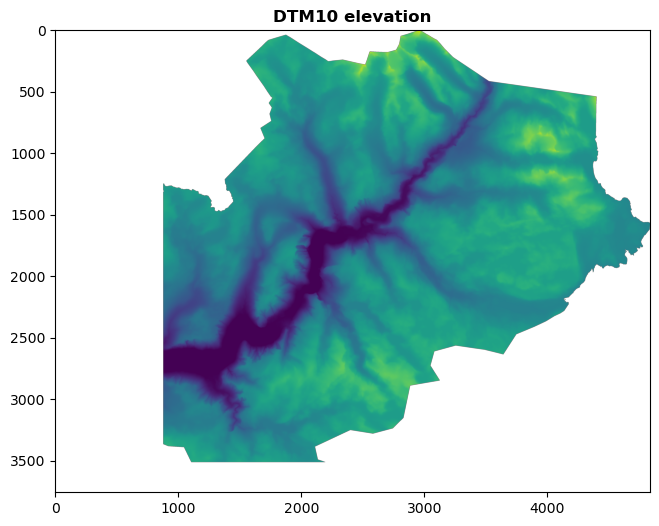

In [1]:
from pathlib import Path

import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np

dtm_path = Path("data/processed/raster/terrain/ardal_dem10.tif")

with rasterio.open(dtm_path) as src:
    print("CRS:", src.crs)
    print("Bounds:", src.bounds)
    print("Resolution:", src.res)
    print("Width x Height:", src.width, "x", src.height)
    
    dtm = src.read(1, masked=True)  # first (and only) band

print("Min/Max/Mean:", dtm.min(), dtm.max(), dtm.mean())

plt.figure(figsize=(8, 6))
show(dtm, title="DTM10 elevation")
plt.show()


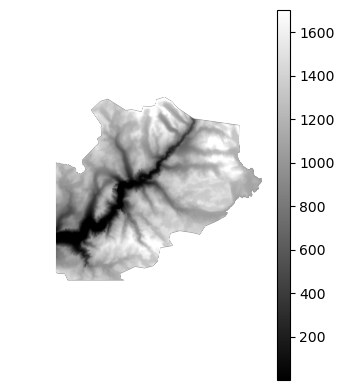

{'vmin': np.float64(0.699999988079071), 'vmax': np.float64(1702.0999755859375)}

In [3]:
import richdem as rd
slope = rd.LoadGDAL("data/derived/rasters/ardal_slope_deg.tif")
flow = rd.LoadGDAL("data/processed/raster/terrain/ardal_dem10.tif")
twi = rd.LoadGDAL("data/derived/rasters/ardal_twi.tif")
rd.rdShow(flow, axes=False)


In [5]:
import pandas as pd

df = pd.read_parquet("data/processed/features/ardal_house_landslide_dataset.parquet")
df.head()


bygningsnummer  dist_landslide_m  y_landslide   elev_dtm10  slope_deg  \
0          316377       1177.949770            0  1053.300049   5.690046   
1          297313         22.039013            1    17.700001  14.240769   
2          297321        175.564051            0   113.900002  21.583786   
3          297348         50.863793            1    31.200001  18.259464   
4          297356        167.025585            0    38.500000   8.743333   

        twi  
0  7.827664  
1  4.772418  
2  7.036595  
3  4.104593  
4  5.784147

In [6]:
links = df.copy()
print(links.head())
print(len(links[links['y_landslide'] == 0]), "distinct events linked to houses")


   bygningsnummer  dist_landslide_m  y_landslide   elev_dtm10  slope_deg  \
0          316377       1177.949770            0  1053.300049   5.690046   
1          297313         22.039013            1    17.700001  14.240769   
2          297321        175.564051            0   113.900002  21.583786   
3          297348         50.863793            1    31.200001  18.259464   
4          297356        167.025585            0    38.500000   8.743333   

        twi  
0  7.827664  
1  4.772418  
2  7.036595  
3  4.104593  
4  5.784147  
3928 distinct events linked to houses


# ML model
HOUSES_GPKG = Path("../data/processed/vector/exposure/houses_ardal_with_dtm10.gpkg")


In [7]:
import geopandas as ppd
from pathlib import Path
import geopandas as gpd
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
HOUSES_GPKG = Path("data/processed/vector/exposure/houses_ardal_with_dtm10.gpkg")

houses = gpd.read_file(HOUSES_GPKG, layer="houses")

In [3]:
HYDRO_GPKG = "../data/processed/vector/hydro/ardal_hydro.gpkg"
RIVERS_LAYER = "rivers"
LAKES_LAYER = "lakes"

rivers = gpd.read_file(HYDRO_GPKG, layer=RIVERS_LAYER).to_crs(25833)
lakes = gpd.read_file(HYDRO_GPKG, layer=LAKES_LAYER).to_crs(25833)

rivers_union = rivers.unary_union
lakes_union = lakes.unary_union

houses["dist_river"] = houses.geometry.apply(lambda g: g.distance(rivers_union))
houses["dist_lake"] = houses.geometry.apply(lambda g: g.distance(lakes_union))


/var/folders/t_/y1zy_tj51c35tggpc_c8twp40000gn/T/ipykernel_44199/1668890392.py:8: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  rivers_union = rivers.unary_union
/var/folders/t_/y1zy_tj51c35tggpc_c8twp40000gn/T/ipykernel_44199/1668890392.py:9: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  lakes_union = lakes.unary_union


In [5]:
EVENTS_GPKG = Path("../data/testing/vector/hazard/ardal_events_2.gpkg")
EVENTS_LAYER = "landslides"

events = gpd.read_file(EVENTS_GPKG, layer=EVENTS_LAYER)
events_union = events.union_all()
houses["dist_skred"] = houses.geometry.apply(lambda geom: geom.distance(events_union))

# Label: within 50 m of any landslide
R = 50  # meters
houses["is_skred_house"] = (houses["dist_skred"] <= R).astype(int)

houses[["bygningsnummer", "dist_skred", "is_skred_house"]].head()


bygningsnummer   dist_skred  is_skred_house
0          316377  1177.949770               0
1          297313    22.039013               1
2          297321   175.564051               0
3          297348    50.863793               0
4          297356   167.025585               0

In [6]:
from sklearn.model_selection import train_test_split

feature_cols = ["elev_dtm10", "dist_river", "dist_lake","twi"]
# add slope later: feature_cols += ["slope"]

X = houses[feature_cols].copy()
y = houses["is_skred_house"]

# basic train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)


              precision    recall  f1-score   support

           0       0.92      0.99      0.95      1179
           1       0.61      0.14      0.23       119

    accuracy                           0.91      1298
   macro avg       0.76      0.57      0.59      1298
weighted avg       0.89      0.91      0.89      1298



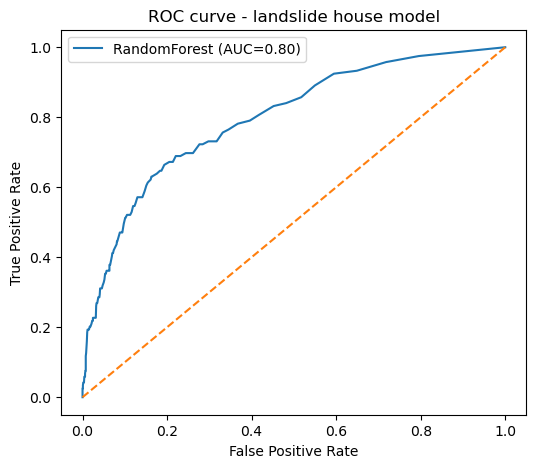

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import roc_curve


rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight="balanced",  # helps if positives are rare
    random_state=42,
    n_jobs=-1,
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
fpr, tpr, threshold = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"RandomForest (AUC={roc_auc_score(y_test, y_proba):.2f})")
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve - landslide house model")
plt.legend()
plt.show()


In [17]:
houses["skred_risk_prob"] = rf.predict_proba(houses[feature_cols])[:, 1]


In [ ]:
out_path = "../data/processed/vector/exposure/houses_ardal_with_skred_risk.gpkg"
houses.to_file(out_path, layer="houses_risk", driver="GPKG")


In [20]:

importances = pd.Series(rf.feature_importances_, index=feature_cols)
print(importances.sort_values(ascending=False))


dist_lake     0.370082
elev_dtm10    0.283828
dist_river    0.216171
twi           0.129920
dtype: float64


In [12]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import numpy as np 

from sklearn.model_selection import train_test_split

target_col = "y_landslide"

# Drop non-feature columns (adjust this list if you have more IDs)
drop_cols = ["bygningsnummer", target_col,"dist_landslide_m"]

# If you *don’t* want to use dist_landslide_m as a feature, add it to drop_cols
# drop_cols.append("dist_landslide_m")

feature_cols = [c for c in df.columns if c not in drop_cols]

X = df[feature_cols].copy()
y = df[target_col].copy()
# How many NaNs per feature?
X.isna().sum().sort_values(ascending=False)

print("Features:", feature_cols)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape



Features: ['elev_dtm10', 'slope_deg', 'twi']


((3026, 3), (1298, 3))

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

log_reg_clf = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(class_weight="balanced", max_iter=1000)),
    ]
)
log_reg_clf.fit(X_train, y_train)


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

Accuracy: 0.6471494607087828
ROC-AUC: 0.6604443304039171

Classification report:
              precision    recall  f1-score   support

           0       0.94      0.65      0.77      1179
           1       0.14      0.58      0.23       119

    accuracy                           0.65      1298
   macro avg       0.54      0.62      0.50      1298
weighted avg       0.87      0.65      0.72      1298


Confusion matrix:


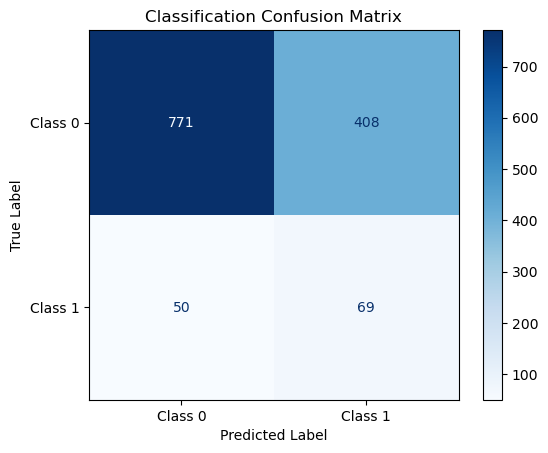

In [15]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score
)
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = log_reg_clf.predict(X_test)
y_proba = log_reg_clf.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification report:")
print(classification_report(y_test, y_pred))

print("\nConfusion matrix:")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues) # Use a color map for better visualization

# 4. Add titles and labels (optional, but recommended)
plt.title('Classification Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 5. Show the plot
plt.show()


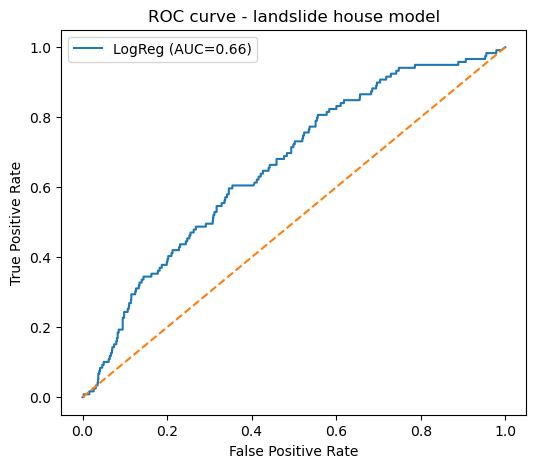

In [16]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"LogReg (AUC={roc_auc_score(y_test, y_proba):.2f})")
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve - landslide house model")
plt.legend()
plt.show()


In [17]:
import geopandas as gpd
import folium
from pathlib import Path

HOUSES_GPKG = Path("../data/processed/vector/exposure/houses_ardal_flom.gpkg")
HOUSES_LAYER = "houses_flom"

out_path = Path("../culvert_version/data/processed/vector/exposure/houses_ardal_flom_preds.gpkg")

gdf = gpd.read_file(out_path, layer="houses_flom_preds_clean").to_crs(4326)
gdf1 = gpd.read_file(HOUSES_GPKG, layer="houses_flom").to_crs(4326)

# Reproject to WGS84 for web maps
gdf_wgs = gdf


center = [gdf_wgs.geometry.y.mean(), gdf_wgs.geometry.x.mean()]
m = folium.Map(location=center, zoom_start=11, tiles="OpenStreetMap")

for _, row in gdf_wgs.iterrows():
    row2 = gdf1[gdf1['bygningsnummer']==row['bygningsnummer']]
    true_cls = row2.get("hazard_class_flom", None)
    pred_cls = row.get("pred_class_flom", None)
    p_high   = row.get("pred_p_high", None)

    # choose which to color by: predicted class
    cls = pred_cls if pred_cls is not None else true_cls

    if cls == 2:
        color = "red"
    elif cls == 1:
        color = "orange"
    else:
        color = "green"

    popup_lines = []
    if true_cls is not None:
        popup_lines.append(f"True class: {(true_cls)}")
    if pred_cls is not None:
        popup_lines.append(f"Pred class: {(pred_cls)}")
    if p_high is not None:
        popup_lines.append(f"p(high) = {p_high:.2f}")

    popup_text = "<br>".join(popup_lines) if popup_lines else "No info"

    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=4,
        color=color,
        fill=True,
        fill_opacity=0.8,
        popup=folium.Popup(popup_text, max_width=250),
    ).add_to(m)

m  # in notebook this should render
